# Build Document Research - Multi-Agent RAG system


**Objective**: a multi-agent RAG tool designed to help you ask questions about your documents and receive fact-checked, avoid hallucination answers by using reflection pattern asking system to evaluate the answer.


## Install Required Libraries


In [1]:
%%capture
%pip install langchain-ibm==0.3.10
%pip install langchain==0.3.23
%pip install langchain_community==0.3.21
%pip install langchain-openai==0.3.27
%pip install langgraph==0.6.6
%pip install pygraphviz==1.14
%pip install docling==2.15.0
%pip install docling-core==2.16.0
%pip install docling-ibm-models==3.3.0
%pip install docling-parse==3.1.2
%pip install langchain-text-splitters==0.3.5
%pip install 'unstructured[ocr]==0.16.17'

In [2]:
%pip install langfuse
%pip install python-dotenv
%pip install pymupdf
%pip install chromadb
%pip install rank_bm25

  Using cached googleapis_common_protos-1.72.0-py3-none-any.whl.metadata (9.4 kB)
Using cached googleapis_common_protos-1.72.0-py3-none-any.whl (297 kB)
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.0
    Uninstalling wrapt-2.0.0:
      Successfully uninstalled wrapt-2.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/10 [langfuse]  9/10 [langfuse]s-common-protos]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 15.1 MB/s  0:00:015.0 MB/s eta 0:00:01:01
Note: you may need to restart the kernel to use updated packages.
  Using cached uvicorn-0.38.0-py3-none-any.whl.metadata (6.8 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached overrides-7.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached google_auth-2.43.0-py2.py3-

In [3]:
## Constants
HYBRID_RETRIEVER_WEIGHTS = [0.4, 0.6] # [ bm25, vector_retriever ]
VECTOR_SEARCH_K = 10
TOP_K = 3

In [6]:
from dotenv import load_dotenv
import os

# Load env
load_dotenv() 

LANGFUSE_SECRET_KEY = os.getenv("LANGFUSE_SECRET_KEY")
LANGFUSE_PUBLIC_KEY = os.getenv("LANGFUSE_PUBLIC_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGFUSE_BASE_URL = os.getenv("LANGFUSE_BASE_URL")

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY 

## Import Required Libraries


In [7]:
# LangGraph modules
from langgraph.graph import StateGraph, END, START

# Type Safety and State Management
from typing import TypedDict, Annotated, List, Literal
from pydantic import BaseModel, Field
import operator
from pprint import pprint

# Graph visualization
from IPython.display import Image, display

# LangChain and LLM 
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# Document Process
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader

# Vector database
from langchain_community.vectorstores import Chroma

/Users/hakieuanh/anaconda3/envs/chatbot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Process documents and Retrieve


### PDF parsing and chunkings

Steps:

- Convert the PDF to Markdown using Docling.
- Split the Markdown into smaller, meaningful chunks using MarkdownHeaderTextSplitter.
- Output the chunks for further processing or embedding.

I using this method to split the text into semantic chunks. This preserves headers and sections, producing coherent chunks that are better for retrieval and question-answering tasks, compared to PyPDFLoader, which extracts raw text and splits it by pages or characters without considering document structure.


In [10]:
file_path = "../data/1706.03762v7.pdf"

In [11]:
from docling.document_converter import DocumentConverter
from langchain_text_splitters import MarkdownHeaderTextSplitter


def process_pdf_to_chunks(file_path: str):
    # Step 1: Convert the PDF to Markdown
    converter = DocumentConverter()
    markdown = converter.convert(file_path).document.export_to_markdown()
    
    # Step 2: Split the Markdown text by headers
    headers = [("#", "Header 1"), ("##", "Header 2")]
    splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers)
    chunks = splitter.split_text(markdown)
    
    return chunks

chunks = process_pdf_to_chunks(file_path)

/Users/hakieuanh/anaconda3/envs/chatbot/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [12]:
chunks

[Document(metadata={}, page_content='Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.'),
 Document(metadata={'Header 2': 'Attention Is All You Need'}, page_content='Ashish Vaswani ∗ Google Brain avaswani@google.com  \nNoam Shazeer ∗ Google Brain noam@google.com  \nNiki Parmar ∗ Google Research nikip@google.com  \nJakob Uszkoreit ∗ Google Research usz@google.com  \nLlion Jones ∗ Google Research llion@google.com  \nAidan N. Gomez ∗ † University of Toronto aidan@cs.toronto.edu  \nŁukasz Kaiser Google Brain lukaszkaiser@google.com  \n∗  \nIllia Polosukhin ∗ ‡  \nillia.polosukhin@gmail.com'),
 Document(metadata={'Header 2': 'Abstract'}, page_content='The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an a

### Retrieval


In [13]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
import logging

In [14]:
## Embedding
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large",
)
embeddings.embedding_ctx_length

8191

In [15]:
import tiktoken

# Check if we have exceed token
tokenizer = tiktoken.encoding_for_model("text-embedding-3-large")

def count_tokens(text):
    tokens = tokenizer.encode(text)
    return len(tokens)

MAX_TOKENS = embeddings.embedding_ctx_length 

for chunk in chunks:
    if count_tokens(chunk.page_content) > MAX_TOKENS:
        print("Invalid chunk exceed token length")

We build hybrid retrieval with combined BM25 and similarity search


In [16]:
def build_hybrid_retriever(chunks):
        """Build a hybrid retriever using BM25 and vector-based retrieval."""
        try:
            # Create Chroma vector store
            vector_store = Chroma.from_documents(chunks, embeddings)
            
            # Create BM25 retriever
            bm25 = BM25Retriever.from_documents(chunks)
            
            # Create vector-based retriever
            vector_retriever = vector_store.as_retriever(search_kwargs={"k": VECTOR_SEARCH_K})
            
            # Combine retrievers into a hybrid retriever
            hybrid_retriever = EnsembleRetriever(
                retrievers=[bm25, vector_retriever],
                weights=HYBRID_RETRIEVER_WEIGHTS
            )
            print("Hybrid retriever created successfully.")
            return hybrid_retriever
        except Exception as e:
            print(f"Failed to build hybrid retriever: {e}")
            raise

retriever = build_hybrid_retriever(chunks)

Hybrid retriever created successfully.


## Define Agents

As our structure, we want to have

- `relevence_checker agent`: check if the questions is relevence within the document => if NO, return "Your question is not found in the document"
  => if YES, pass to research agent
- `research agent`: retrieve in the document
- `verification agent`: check the research agent answer, verify
  => if NO, return back to research agent (reflection pattern)
  => if YES, return the answer


In [17]:
# required libraries in the following cells starting
from langgraph.graph import StateGraph, END, START
from langgraph.types import Send

# type safety and state management
from typing import TypedDict, Annotated, List, Literal
from pydantic import BaseModel, Field
import operator
from pprint import pprint
from langchain.schema import Document

### State


In [18]:
question_type = Literal[
    'CAN_ANSWER',
    'PARTIAL',
    'NO_ANSWER'
] 

## Output Verify Agent Schema
from pydantic import BaseModel, Field
from typing import List

class VerifyResult(BaseModel):
    Supported: str = Field(
        ...,
        description="Indicates if the claim or answer is supported. Expected values: 'YES' or 'NO'."
    )
    Unsupported_Claims: List[str] = Field(
        default_factory=list,
        description="List of claims that are unsupported or not verified."
    )
    Contradictions: List[str] = Field(
        default_factory=list,
        description="List of items that contradict the claim or answer."
    )
    Relevant: str = Field(
        ...,
        description="Indicates if the information is relevant to the query. Expected values: 'YES' or 'NO'."
    )
    Additional_Details: List[str] = Field(
        default_factory=list,
        description="Additional information or explanations related to the verification result."
    )


class State(TypedDict):
    question: str
    answer: str
    context: str
    q_type: question_type # classify the question
    documents: List[Document]
    report:VerifyResult
    n: int = 0 # nb of iteration

### Relevence Checker Agent


In [19]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# Initialize the language model - using gpt-4o-mini for cost-effective experimentation
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) # temperature 0 - determistic output

In [20]:
from langchain.prompts import ChatPromptTemplate

relevance_checker_prompt = ChatPromptTemplate.from_template(
    """
    You are an AI relevance checker between a user's question and provided document content.
    
    **Instructions:**
    - Classify how well the document content addresses the user's question.
    - Respond with only one of the following labels: CAN_ANSWER, PARTIAL, NO_ANSWER.
    - Do not include any additional text or explanation.
    
    **Labels:**
    1) "CAN_ANSWER": The passages contain enough explicit information to fully answer the question.
    2) "PARTIAL": The passages mention or discuss the question's topic but do not provide all the details needed for a complete answer.
    3) "NO_ANSWER": The passages do not discuss or mention the question's topic at all.
    
    **Important:** If the passages mention or reference the topic or timeframe of the question in any way, even if incomplete, respond with "PARTIAL" instead of "NO_MATCH".
    
    **Question:** {question}
    **Passages:** {document_content}
    
    **Respond ONLY with one of the following labels: CAN_ANSWER, PARTIAL, NO_ANSWER**
    """
)


In [21]:
relevance_checker_pipe = relevance_checker_prompt | llm

In [22]:
def relevance_checker(state: State):
    """
        1. Retrieve the top-k document chunks from the global retriever.
        2. Combine them into a single text string.
        3. Pass that text + question to the LLM for classification.
    """
    top_docs = retriever.invoke(state.get("question", ""))
    if not top_docs:
        return "NO_MATCH"
    
    # Combine the top k chunk texts into one string
    document_content = "\n\n".join(doc.page_content for doc in top_docs[:TOP_K])

    try:
        response = relevance_checker_pipe.invoke({
            "question": state.get("question", ""),
            "document_content": document_content
        })
        q_type = response.content.lower()
    except Exception as e:
        print(f"Error invoking relevance_checker_pipe: {e}")
        q_type = "error"

    return {"q_type": response.content.upper(), "documents": top_docs}

Test the agent with dump input


In [23]:
# Dummy State input
dummy_state = {
    "question": "What is the main topic of the document?",
    "q_type": "NO_ANSWER",  # Initial placeholder
    "n": 0
}

# Assuming k=3 for top 3 document chunks
result = relevance_checker(dummy_state)

print("Relevance Checker Output:", result)

Relevance Checker Output: {'q_type': 'PARTIAL', 'documents': [Document(metadata={'Header 2': '2 Background'}, page_content='The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU [16], ByteNet [18] and ConvS2S [9], all of which use convolutional neural networks as basic building block, computing hidden representations in parallel for all input and output positions. In these models, the number of operations required to relate signals from two arbitrary input or output positions grows in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes it more difficult to learn dependencies between distant positions [12]. In the Transformer this is reduced to a constant number of operations, albeit at the cost of reduced effective resolution due to averaging attention-weighted positions, an effect we counteract with Multi-Head Attention as described in section 3.2.  \nSelf-attention, sometimes called intra-attentio

### Research Agent


In [24]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

llm = ChatOpenAI(
    model="gpt-4-turbo",
    temperature=0.3,  
    max_tokens=300 # desired response length
)

In [25]:
generate_draft_answer = ChatPromptTemplate.from_template(
    """
    You are an AI assistant designed to provide precise and factual answers based on the given context.
    
    **Instructions:**
    - Answer the following question using only the provided context.
    - Be clear, concise, and factual.
    - Return as much information as you can get from the context.
    
    **Question:** {question}
    **Context:**
    {context}
    
    **Provide your answer below:**
    """
)

In [26]:
generate_draft_pipe = generate_draft_answer | llm

In [27]:
def generate_draft(state:State):
    documents = state.get("documents")

    if documents: 
        # Combine the top document contents into one string
        context = "\n\n".join([doc.page_content for doc in documents])
    else:
        context = ""

    try:    
        response = generate_draft_pipe.invoke({
            "question": state.get("question", ""),
            "context": context
        })
        
        llm_response = response.content.strip()
    except Exception as e:
        print(f"Error invoking generate_draft pipeline : {e}")
        llm_response = "error"

    return {"answer": llm_response, "context": context}

### Verify Agent


In [28]:
llm = ChatOpenAI(
    model="gpt-4",
    temperature=0,  
    max_tokens=300, # desired response length
)

In [29]:
verify_answer_prompt = ChatPromptTemplate.from_template(
    """
    You are an AI assistant designed to verify the accuracy and relevance of answers based on provided context.

    **Instructions:**
    - Verify the following answer against the provided context.
    - Check for:
    1. Direct/indirect factual support (YES/NO)
    2. Unsupported claims (list any if present)
    3. Contradictions (list any if present)
    4. Relevance to the question (YES/NO)
    - Provide additional details or explanations where relevant.
    - Respond in the exact format specified below without adding any unrelated information.

    **Format:**
    Supported: YES/NO
    Unsupported Claims: [item1, item2, ...]
    Contradictions: [item1, item2, ...]
    Relevant: YES/NO
    Additional Details: [Any extra information or explanations]

    **Answer:** {answer}
    **Context:**
    {context}

    **Respond ONLY with the above format.**
    """
)

In [30]:
verify_answer_pipe = verify_answer_prompt | llm.with_structured_output(VerifyResult)

/Users/hakieuanh/anaconda3/envs/chatbot/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1857: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [34]:
def verify_check(state:State):
    documents = state.get("documents")
    
    if documents: 
        # Combine the top document contents into one string
        context = "\n\n".join([doc.page_content for doc in documents])
    else:
        context = ""

    try:    
        response = verify_answer_pipe.invoke({
            "answer": state.get("answer", ""),
            "context": context
        })
        
        verification_report_formatted = (
            f"Supported: {response.Supported if response.Supported else 'NO'}\n"
            f"Unsupported Claims: {response.Unsupported_Claims if response.Unsupported_Claims else []}\n"
            f"Contradictions: {response.Contradictions if response.Contradictions else []}\n"
            f"Relevant: {response.Relevant if response.Relevant else 'NO'}\n"
            f"Additional Details: {response.Additional_Details if response.Additional_Details else []}\n"
        )
        
    except Exception as e:
        print(f"Error invoking verify_answer_pipe pipeline : {e}")
        verification_report_formatted = {
            "Supported": "NO",
            "Unsupported Claims": [],
            "Contradictions": [],
            "Relevant": "NO",
            "Additional Details": ["Failed to parse the model's response."]
        }

    return {"report": verification_report_formatted}

## Build Workflow


### Route


In [35]:
def check_relevance(state:State):
    """Route relevance_checker base on relevance level of the question"""
    # print("State", state) 
    question_type = state.get("q_type", "NO_ANSWER")
    
    if question_type == 'CAN_ANSWER' or question_type == 'PARTIAL':
        return "relevance"
        
    if question_type == 'NO_ANSWER':
        return "irrelevant"

In [36]:
def route_research(state:State):
    """Route to re-research if the answer not qualified"""
    verification_report = state.get("report") 
    if verification_report:
        if "Supported: NO" in verification_report or "Relevant: NO" in verification_report:
            return "re_research"
        else:
            return "end"
    else:
        return "end"

### Flow with LangGraph


In [40]:
workflow = StateGraph(State)

# Nodes
workflow.add_node("check_relevance", relevance_checker)
workflow.add_node("research", generate_draft)
workflow.add_node("verify", verify_check)
workflow.add_node("irrelevant_handler", lambda state: {
    **state,
    "answer": "This question isn't related (or there's no data) for your query. Please ask related question."
})

# Edges
workflow.set_entry_point("check_relevance")
workflow.add_conditional_edges(
    "check_relevance",
    check_relevance,
    {
        "relevance": "research",
        "irrelevant": "irrelevant_handler"
    }
)
workflow.add_edge("irrelevant_handler", END)

workflow.add_edge("research", "verify")
workflow.add_conditional_edges(
    "verify",
    route_research,
    {
        "re_research": "research",
        "end": END
    }
)

In [41]:
# compile the workflow
reflection_workflow = workflow.compile()

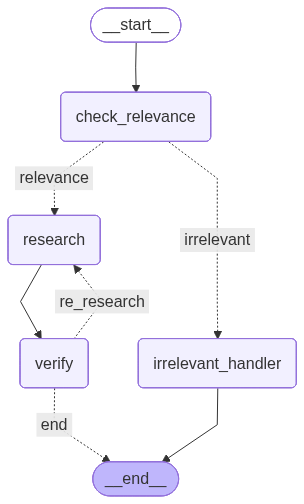

In [42]:
# display the graph
display(Image(reflection_workflow.get_graph().draw_mermaid_png()))

## Testing


In [43]:
response = reflection_workflow.invoke({
   "question": "What is transformer?"
})

print("The question is", response['q_type'])
print(response['answer'])

The question is CAN_ANSWER
The Transformer is a model architecture used primarily for sequence transduction tasks, such as machine translation. It is unique in that it relies entirely on an attention mechanism, specifically multi-head self-attention, to compute representations of its input and output without using recurrent neural networks (RNNs) or convolutional neural networks (CNNs). This design allows for greater parallelization during training and reduces the time required to train the model, achieving state-of-the-art results in tasks like English-to-German and English-to-French translation.

The Transformer model consists of an encoder and a decoder, each with multiple layers. The encoder maps an input sequence of symbols to a sequence of continuous representations, while the decoder generates an output sequence of symbols one at a time, based on the encoder's output and the previously generated output symbols. Both the encoder and decoder are composed of stacks of identical lay

In [44]:
# Unrelated question
response_ir = reflection_workflow.invoke({
    "question": "What is the weather today?"
})
print("The question is", response_ir['q_type'])
print(response_ir['answer'])

The question is NO_ANSWER
This question isn't related (or there's no data) for your query. Please ask related question.


### Tracing call with Langfuse

I want to what happens when my agent runs. Using Langfuse i can see every trace, every cost, every token.


In [46]:
from langfuse.langchain import CallbackHandler

langfuse_handler = CallbackHandler()

response = reflection_workflow.invoke(
   {"input": "What are the main topics discussed?"},
   config={"callbacks": [langfuse_handler]}
)

print(response["answer"])

The Transformer model, proposed by Vaswani et al., is a new network architecture that relies entirely on attention mechanisms, eliminating the need for recurrence and convolutions. This model is designed to be highly parallelizable and efficient in training time. It has demonstrated superior performance on machine translation tasks, achieving a BLEU score of 28.4 on the WMT 2014 English-to-German translation and a new state-of-the-art BLEU score of 41.8 on the WMT 2014 English-to-French translation. The Transformer also generalizes well to other tasks like English constituency parsing.

The architecture features a novel method called "Scaled Dot-Product Attention," and a "Multi-Head Attention" mechanism that allows the model to attend to information from different representation subspaces simultaneously. Each layer of the encoder and decoder includes a fully connected feed-forward network, applied identically to each position. The model uses the Adam optimizer with a specific learning 